# Multiedge dichroic analysis
If we could use a five-edge dichroic, we would significantly reduce the complexity of the instrument for wide field fluorescence. On the other hand, this is relatively expensive (Laser2000 suggest ~10k for Semrock, Chroma waiting for whether we're satisfied with spec before providing a quote) and locks us in to some extent to the current set of fluorophores. Perhaps most significantly, the increased complexity of the fabrication process will result in a performance drop in terms of signal in any one band.

How bad is this performance drop?

First, import files defining the spectral characteristics of the system. 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
# from bokeh.io import push_notebook, show, output_notebook
# from bokeh.plotting import figure
import seaborn as sns

from dye import Dye
from laser import Laser
from filterCube import FilterCube
from camera import Camera
from objective import Objective
import utils
from crosstalk_analysis import signalFromDyeXInChannelY
from crosstalk_analysis import displayCrosstalkPlot

dyesPath = 'Dye spectra/'
filtersPath = 'Filter spectra/'
opticsPath =  'Optics spectra/'
cameraPath = 'Camera spectra/'

%matplotlib inline
# output_notebook()

In [2]:
def show_dye_emission_enclosed_by_filters(dye, filtercube, objective, camera, title='dummy title'):
    """Given dye and filtercube, give visual indication of overlap"""
    
    dem = utils.interpolateSpectrum(dye.emissionSpectrum, 0.5)
    fem = utils.interpolateSpectrum(filtercube.emissionFilter.getSpectrum(), 0.5)
    fdiem = utils.interpolateSpectrum(filtercube.dichroicFilter.getSpectrum(), 0.5)
    spectra = [dem, fem, fdiem]
    
    lowerLimit = max( [min(spectrum[:,0]) for spectrum in spectra] )
    upperLimit = min( [max(spectrum[:,0]) for spectrum in spectra] )
    
    trimmedSpectra = [spectrum[(spectrum[:,0] >= lowerLimit) & (spectrum[:,0] <= upperLimit)] for spectrum in spectra]

    ovrlp = np.ones((trimmedSpectra[0][:,1].shape))
    
    for spectrum in trimmedSpectra:
        ovrlp = np.multiply(ovrlp, spectrum[:,1])
    
    hfig = plt.figure()
    plt.title(filtercube.channel + ' ' + title)
    utils.displaySpectra(trimmedSpectra)
    plt.fill_between(trimmedSpectra[0][:,0], ovrlp)
        
    return np.sum(ovrlp)*0.5

__Sources for dye data:__

Atto general properties: https://www.atto-tec.com/fileadmin/user_upload/Katalog_Flyer_Support/Dye_Properties_01.pdf

Atto spectra: https://www.atto-tec.com/attotecshop/product_info.php?language=en&info=p117_ATTO-700.html

Alexa 405 absorption coefficient: http://www.atdbio.com/content/34/Alexa-dyes

Alexa 405 QY: http://confocal-microscopy-list.588098.n2.nabble.com/alexa-405-QY-td6913848.html

Alexa 405 spectra: https://www.chroma.com/spectra-viewer?fluorochromes=10533


__Sources for filter spectra:__

Semrock filters: http://www.laser2000.co.uk

Chroma 700 dichroics: emailed from Chroma


__Sources for camera spectra:__

Andor Zyla 5.5: https://searchlight.semrock.com/


__Sources for optics (objective) spectra:__

UPLANSAPO20x: https://www.olympus-lifescience.com/en/objectives/uplsapo/#!cms[tab]=%2Fobjectives%2Fuplsapo%2F20x, data extracted from curve using WebPlotDigitiser: http://arohatgi.info/WebPlotDigitizer/app/


Next, define (manually and in a boilerplate-y manner) the components of the system we are investigating. 

In [3]:
dye405 = Dye(name = 'Alexa405', epsilon = 35000, qy = 0.54, 
             absSpectrum = os.path.join(dyesPath, 'Alexa405abs.txt'), 
             emSpectrum = os.path.join(dyesPath, 'Alexa405em.txt'))
          
dye532 = Dye(name = 'Atto532', epsilon = 115000, qy = 0.9, 
             absSpectrum = os.path.join(dyesPath, 'ATTO532_PBS.abs.txt'), 
             emSpectrum = os.path.join(dyesPath, 'ATTO532_PBS.ems.txt'))

dye594 = Dye(name = 'Atto594', epsilon = 120000, qy = 0.85, 
             absSpectrum = os.path.join(dyesPath, 'ATTO594_PBS.abs.txt'), 
             emSpectrum = os.path.join(dyesPath, 'ATTO594_PBS.ems.txt'))

dye633 = Dye(name = "Atto655", epsilon = 125000, qy = 0.3, 
          absSpectrum = os.path.join(dyesPath, 'ATTO655_PBS.abs.txt'), 
          emSpectrum = os.path.join(dyesPath, 'ATTO655_PBS.ems.txt') )        

dye700 = Dye(name = "Atto700", epsilon = 120000, qy = 0.25, 
          absSpectrum = os.path.join(dyesPath, 'ATTO700_PBS.abs.txt'), 
          emSpectrum = os.path.join(dyesPath, 'ATTO700_PBS.ems.txt') )         
          
l405 = Laser(channel = 'L405Nm', centreWavelengthNm = 405, fwhmNm = 0.01, 
             laserOutputPowerMw = 3)
             
l532 = Laser(channel = 'L532Nm', centreWavelengthNm = 532, fwhmNm = 0.01, 
             laserOutputPowerMw = 18)
             
l594 = Laser(channel = 'L594Nm', centreWavelengthNm = 594, fwhmNm = 0.01, 
             laserOutputPowerMw = 25)             
          
l633 = Laser(channel = 'L633Nm', centreWavelengthNm = 640, fwhmNm = 0.01, 
             laserOutputPowerMw = 30)
          
l700 = Laser(channel = 'L700Nm', centreWavelengthNm = 701, fwhmNm = 0.01, 
             laserOutputPowerMw = 30)
             
fc405 = FilterCube(channel = 'L405Nm', 
                   excitationFilter = ( 'FF01-390_40', os.path.join(filtersPath, 'FF01-390_40_Spectrum.txt') ), 
                   dichroicFilter = ( 'Di02-R405', os.path.join(filtersPath, 'Di02-R405_Spectrum.txt') ), 
                   emissionFilter = ( 'FF01-452_45', os.path.join(filtersPath, 'FF01-452_45_Spectrum.txt') ) )
                   
fc532 = FilterCube(channel = 'L532Nm', 
                   excitationFilter = ( 'FF01-532_3', os.path.join(filtersPath, 'FF01-532_3_spectrum.txt') ), 
                   dichroicFilter = ( 'Di02-R532', os.path.join(filtersPath, 'Di02-R532_Spectrum.txt') ), 
                   emissionFilter = ( 'FF01-562_40', os.path.join(filtersPath, 'FF01-562_40_spectrum.txt') ) )
                   
fc594 = FilterCube(channel = 'L594Nm', 
                   excitationFilter = ( 'FF01-591_6', os.path.join(filtersPath, 'FF01-591_6_Spectrum.txt') ), 
                   dichroicFilter = ( 'Di02-R594', os.path.join(filtersPath, 'Di02-R594_Spectrum.txt') ), 
                   emissionFilter = ( 'FF01-647_57', os.path.join(filtersPath, 'FF01-647_57_Spectrum.txt') ) )
             
fc633 = FilterCube(channel = 'L633Nm', 
                   excitationFilter = ( 'FF01-640_14', os.path.join(filtersPath, 'FF01-640_14_spectrum.txt') ), 
                   dichroicFilter = ( 'Di02-R635', os.path.join(filtersPath, 'Di02-R635_Spectrum.txt') ), 
                   emissionFilter = ( 'FF01-679_41', os.path.join(filtersPath, 'FF01-679_41_Spectrum.txt') ) )
                   
fc700old = FilterCube(channel = 'L700Nm', 
                   excitationFilter = ( 'FF01-692_40', os.path.join(filtersPath, 'FF01-692_40_Spectrum.txt') ), 
                   dichroicFilter = ( '725dcxxr', os.path.join(filtersPath, 'Chroma 725dcxxr.txt') ), 
                   emissionFilter = ( 'FF01-795_150', os.path.join(filtersPath, 'FF01-795_150_Spectrum.txt') ) )
                   
fc700new = FilterCube(channel = 'L700Nm', 
                   excitationFilter = ( 'FF01-692_40', os.path.join(filtersPath, 'FF01-692_40_Spectrum.txt') ), 
                   dichroicFilter = ( '725lpxr', os.path.join(filtersPath, 'Chroma 725lpxr.txt') ), 
                   emissionFilter = ( 'FF01-747_33', os.path.join(filtersPath, 'FF01-747_33_Spectrum.txt') ) )

fc405multi = FilterCube(channel = 'L405Nm', 
                   excitationFilter = ( 'FF01-390_40', os.path.join(filtersPath, 'FF01-390_40_Spectrum.txt') ), 
                   dichroicFilter = ( 'Chroma multiedge', os.path.join(filtersPath, 'Chroma ZT405-532-594-640-701rpc.txt') ), 
                   emissionFilter = ( 'FF01-452_45', os.path.join(filtersPath, 'FF01-452_45_Spectrum.txt') ) )
                   
fc532multi = FilterCube(channel = 'L532Nm', 
                   excitationFilter = ( 'FF01-532_3', os.path.join(filtersPath, 'FF01-532_3_spectrum.txt') ), 
                   dichroicFilter = ( 'Chroma multiedge', os.path.join(filtersPath, 'Chroma ZT405-532-594-640-701rpc.txt') ), 
                   emissionFilter = ( 'FF01-562_40', os.path.join(filtersPath, 'FF01-562_40_spectrum.txt') ) )
                   
fc594multi = FilterCube(channel = 'L594Nm', 
                   excitationFilter = ( 'FF01-591_6', os.path.join(filtersPath, 'FF01-591_6_Spectrum.txt') ), 
                   dichroicFilter = ( 'Chroma multiedge', os.path.join(filtersPath, 'Chroma ZT405-532-594-640-701rpc.txt') ), 
                   emissionFilter = ( 'FF01-647_57', os.path.join(filtersPath, 'FF01-647_57_Spectrum.txt') ) )
             
fc633multi = FilterCube(channel = 'L633Nm', 
                   excitationFilter = ( 'FF01-640_14', os.path.join(filtersPath, 'FF01-640_14_spectrum.txt') ), 
                   dichroicFilter = ( 'Chroma multiedge', os.path.join(filtersPath, 'Chroma ZT405-532-594-640-701rpc.txt') ), 
                   emissionFilter = ( 'FF01-679_41', os.path.join(filtersPath, 'FF01-679_41_Spectrum.txt') ) )
                   
fc700multi = FilterCube(channel = 'L700Nm', 
                   excitationFilter = ( 'FF01-692_40', os.path.join(filtersPath, 'FF01-692_40_Spectrum.txt') ), 
                   dichroicFilter = ( 'Chroma multiedge', os.path.join(filtersPath, 'Chroma ZT405-532-594-640-701rpc.txt') ), 
                   emissionFilter = ( 'FF01-747_33', os.path.join(filtersPath, 'FF01-747_33_Spectrum.txt') ) )
                   
                   
camera = Camera(name = 'Andor Zyla 5.5', 
                qeCurve = os.path.join(cameraPath, 'Camera sCMOS (Andor- Zyla 5.5).txt'))

objective = Objective(name = 'Olympus UPLANSAPO20x 0.75NA', 
                      transmissionCurve = os.path.join(opticsPath, 'Olympus UPLANSAPO20x.txt'))



In [4]:
laser_list = [l405, l532, l594, l633, l700]
fc_list = [fc405, fc532, fc594, fc633, fc700new]
multi_fc_list = [fc405multi, fc532multi, fc594multi, fc633multi, fc700multi]
dye_list = [dye405, dye532, dye594, dye633, dye700]


## Signal comparison

Then consider the relative (correct) signal from each of the dyes in their respective detection channels in the new system compared to the current system. Note that dye concentration is not considered so raw signal cannot be compared between channels, but that is is nevertheless valid to compare the two different setups in each channel individually. 

<IPython.core.display.Javascript object>


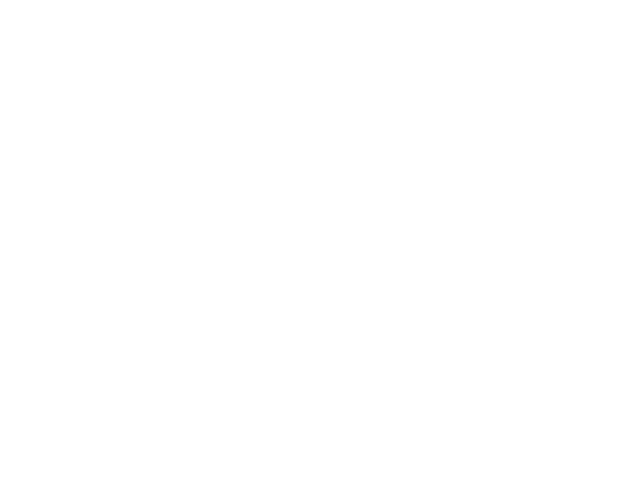

<IPython.core.display.Javascript object>


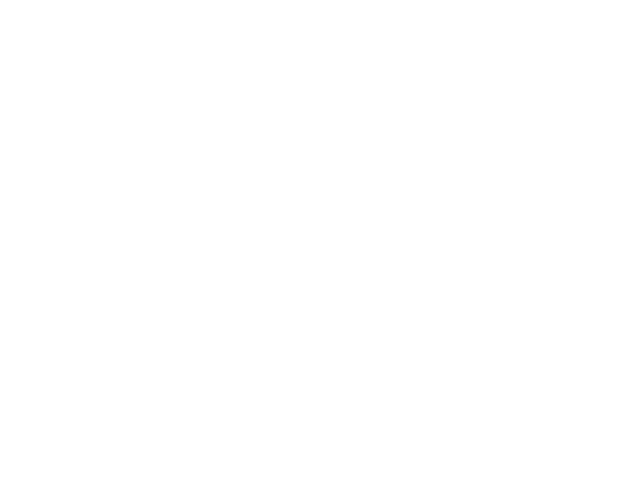

<IPython.core.display.Javascript object>


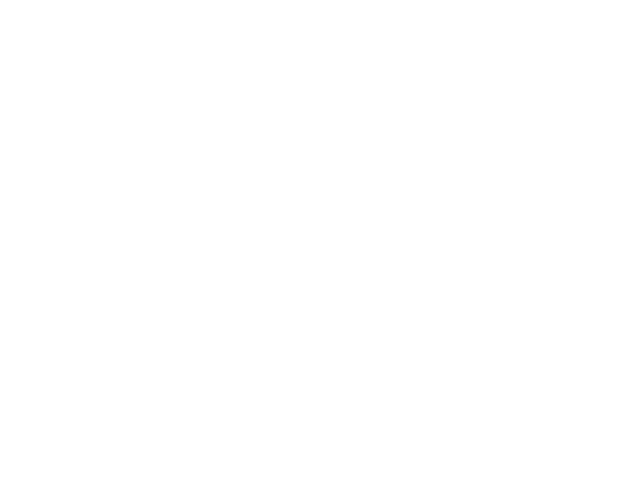

<IPython.core.display.Javascript object>


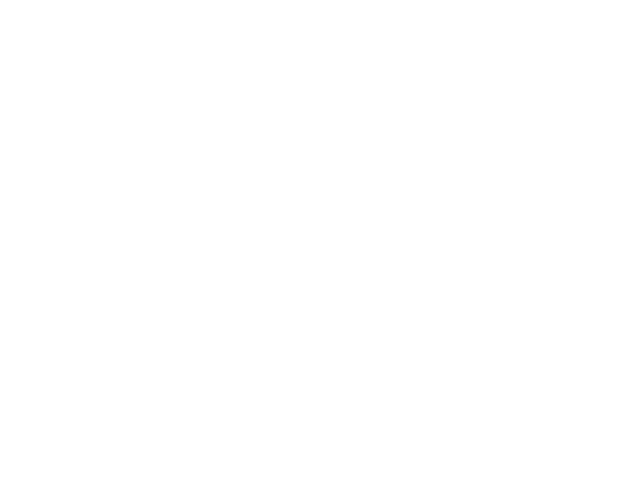

<IPython.core.display.Javascript object>


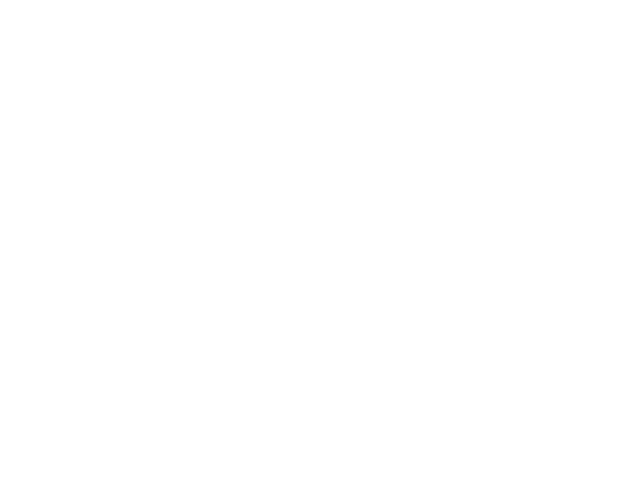

<IPython.core.display.Javascript object>


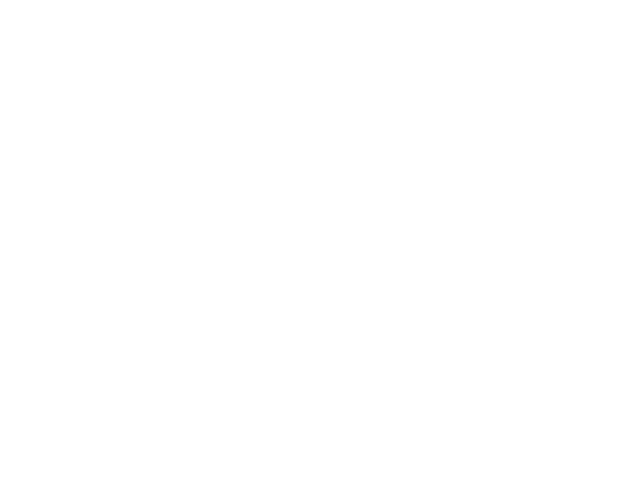

<IPython.core.display.Javascript object>


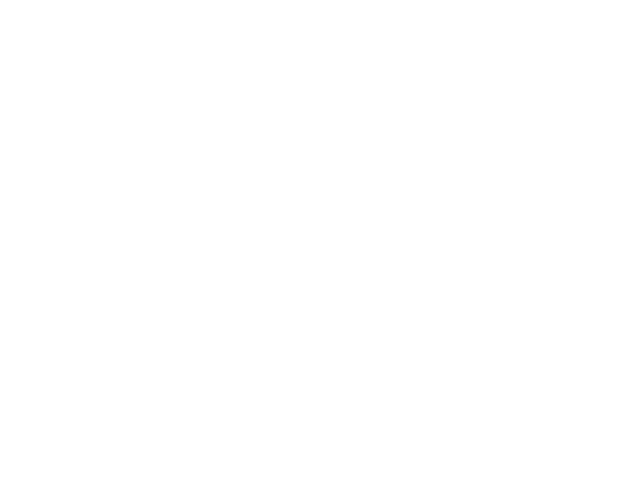

<IPython.core.display.Javascript object>


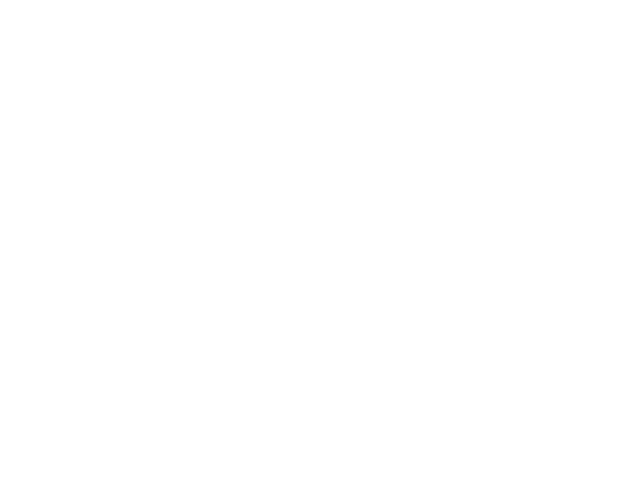

<IPython.core.display.Javascript object>


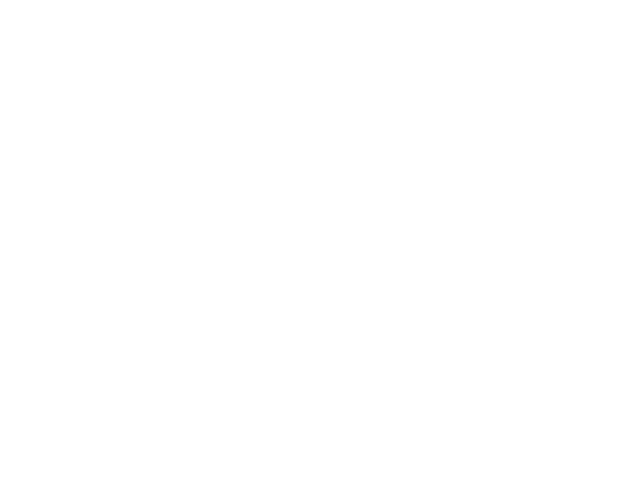

<IPython.core.display.Javascript object>


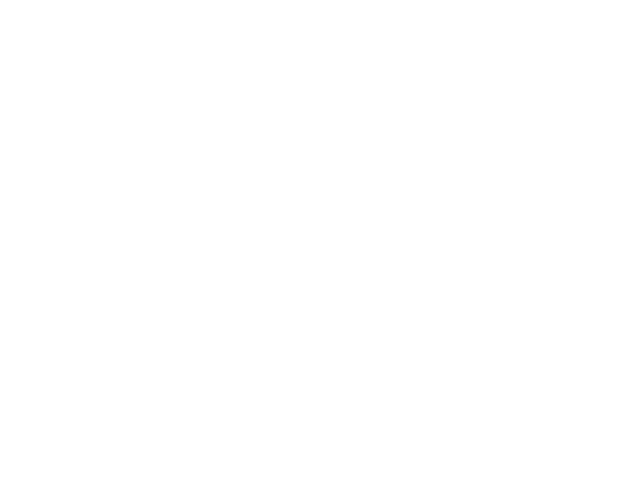

<IPython.core.display.Javascript object>


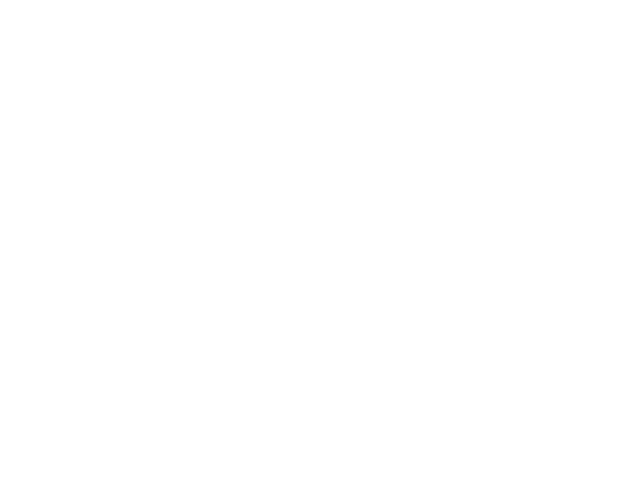

In [5]:
% matplotlib notebook
ratios = []
ch_labels = []

for l, f_old, f_new, dy in zip(laser_list, fc_list, multi_fc_list, dye_list):
    d, ch, sig_new = signalFromDyeXInChannelY(l, f_new, dy, objective, camera)
    d, ch, sig_old = signalFromDyeXInChannelY(l, f_old, dy, objective, camera)
    
    ratios.append(sig_new/sig_old)
    ch_labels.append(ch)
#     print(ch)
    #print(sig_old)
    #print(sig_new)
    #print('Fraction = {}'.format(sig_new/sig_old))
    #fig = plt.figure();
    #plt.title('Old cubes, ' + ch + ' channel')
    #f_old.displaySpectra()
    #fig2 = plt.figure()
    #plt.title('Multiedge cube, ' + ch + ' channel')
    #f_new.displaySpectra()
    ol1 = show_dye_emission_enclosed_by_filters(dy, f_old, objective, camera, title='Separate dichroics')
    ol2 = show_dye_emission_enclosed_by_filters(dy, f_new, objective, camera, title='Multiedge dichroic')

    
fig3 = plt.figure();
plt.bar([1, 2, 3, 4, 5], 
        ratios, 
        tick_label=ch_labels, 
        align='center')
plt.ylabel('Fractional signal, multiedge/separate')
    

## Crosstalk comparison

Consider next the crosstalk between channels:


<IPython.core.display.Javascript object>


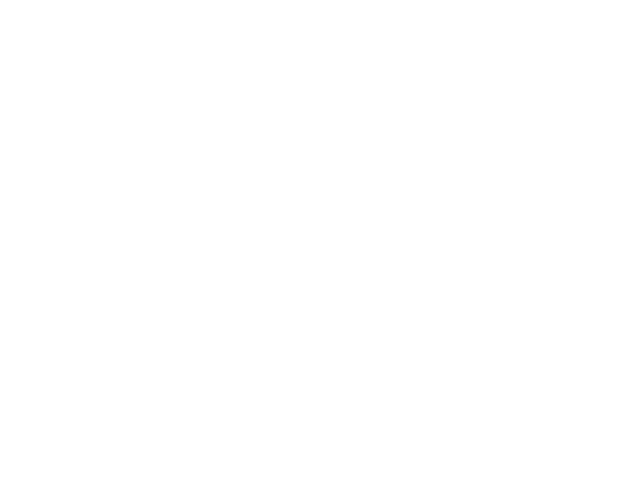

<IPython.core.display.Javascript object>


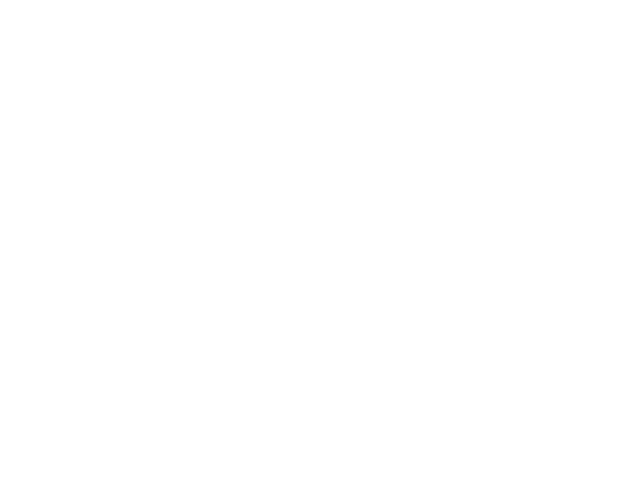

In [6]:
%matplotlib notebook
displayCrosstalkPlot(laser_list, 
                     fc_list, 
                     dye_list, 
                     objective, camera)
                     
plt.title('Separate dichroics')

displayCrosstalkPlot(laser_list, 
                     multi_fc_list, 
                     dye_list, 
                     objective, camera)
                     
plt.title('Multiedge dichroic')

## Alternative emission filters

Can we recover signal by increasing the emission cut-off wavelength in 594 and 633 channels?

<IPython.core.display.Javascript object>


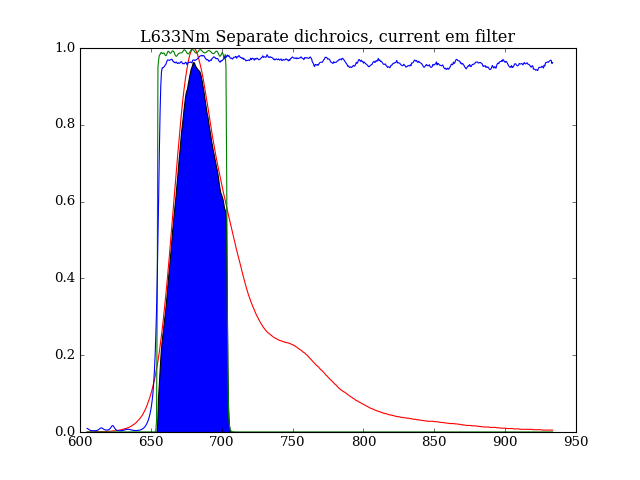

<IPython.core.display.Javascript object>


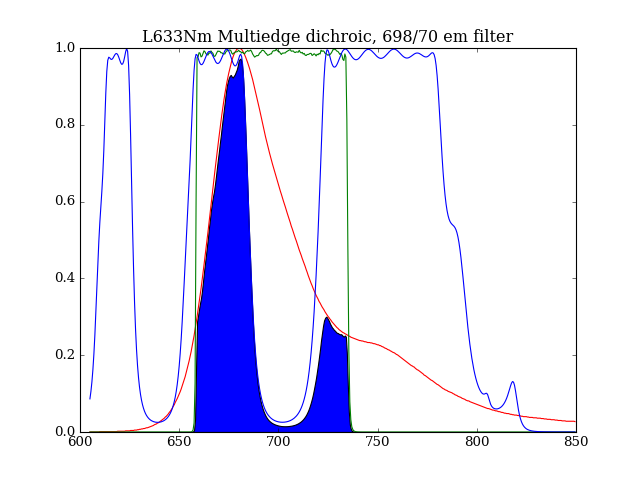

<IPython.core.display.Javascript object>


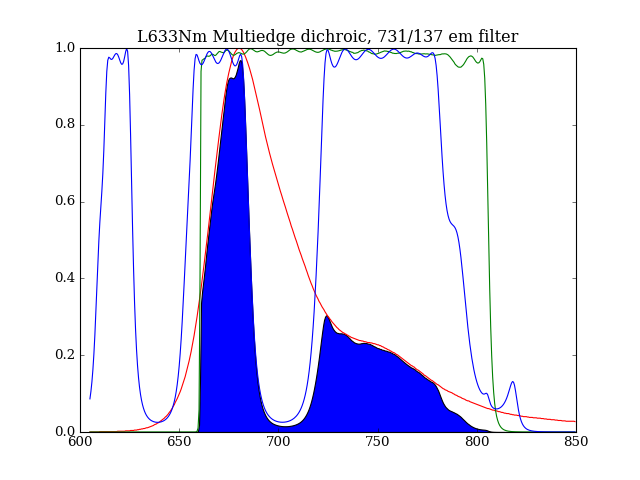

633 signal ratio, 698/70 = 0.731
633 signal ratio, 731/137 = 0.913


<IPython.core.display.Javascript object>


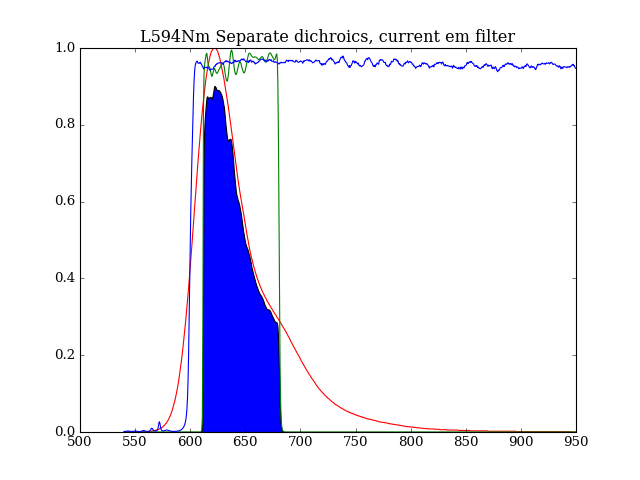

<IPython.core.display.Javascript object>


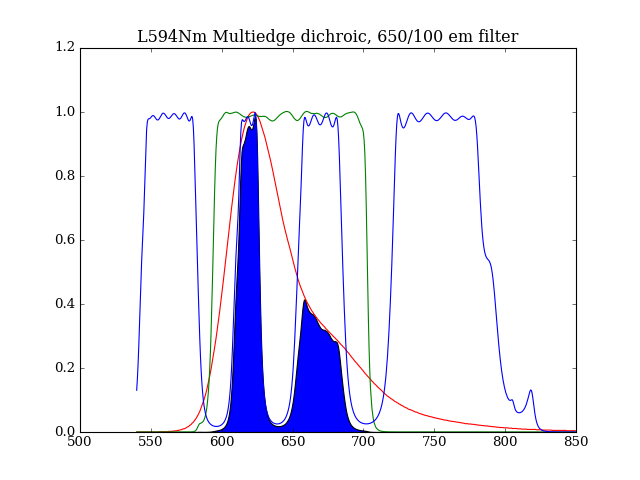

<IPython.core.display.Javascript object>


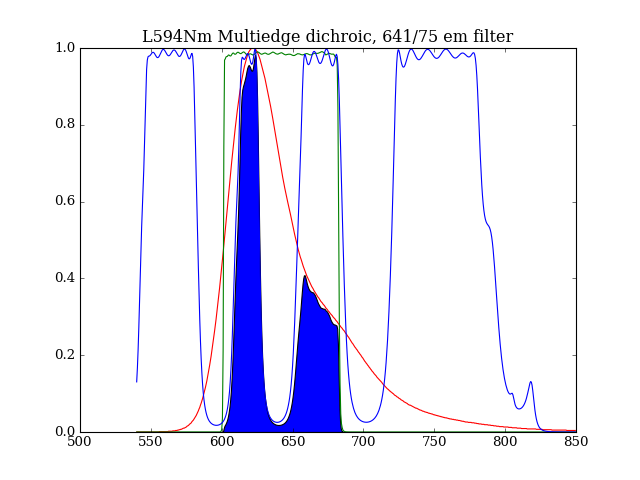

<IPython.core.display.Javascript object>


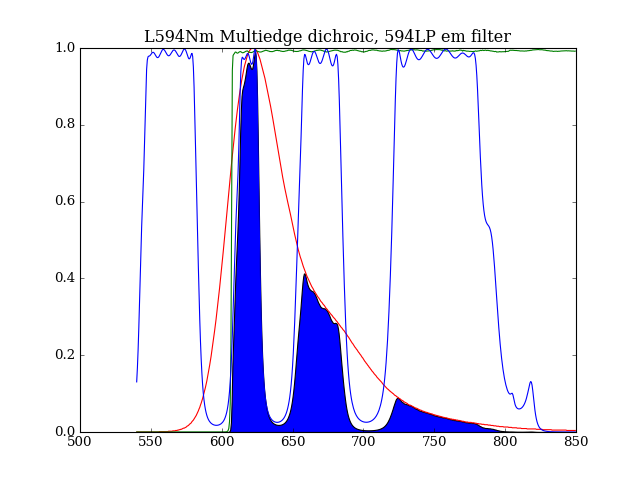

594 signal ratio, 650/100 = 0.685
594 signal ratio, 641/75 = 0.658
594 signal ratio, 594LP = 0.737


<IPython.core.display.Javascript object>


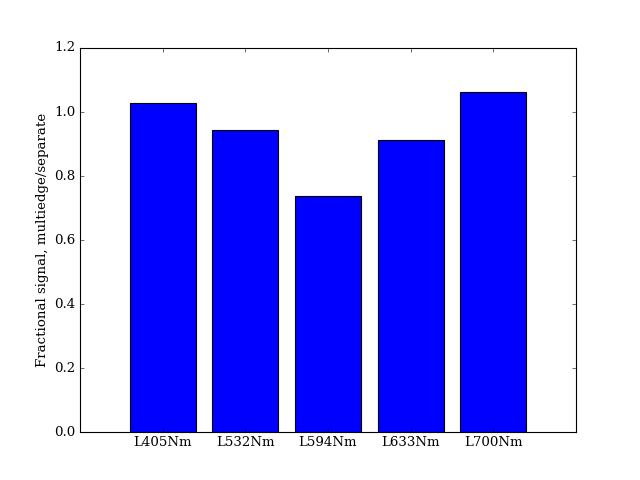

In [7]:
%matplotlib notebook
ratios_maxem = ratios

fc633multi2 = FilterCube(channel = 'L633Nm', 
                   excitationFilter = ( 'FF01-640_14', os.path.join(filtersPath, 'FF01-640_14_spectrum.txt') ), 
                   dichroicFilter = ( 'Chroma multiedge', os.path.join(filtersPath, 'Chroma ZT405-532-594-640-701rpc.txt') ), 
                   emissionFilter = ( 'FF01-698_70', os.path.join(filtersPath, 'FF01-698_70_Spectrum.txt') ) )

fc633multi3 = FilterCube(channel = 'L633Nm', 
                   excitationFilter = ( 'FF01-640_14', os.path.join(filtersPath, 'FF01-640_14_spectrum.txt') ), 
                   dichroicFilter = ( 'Chroma multiedge', os.path.join(filtersPath, 'Chroma ZT405-532-594-640-701rpc.txt') ), 
                   emissionFilter = ( 'FF01-731_137', os.path.join(filtersPath, 'FF01-731_137_Spectrum.txt') ) )

d, ch, sig_new2 = signalFromDyeXInChannelY(l633, fc633multi2, dye633, objective, camera)
d, ch, sig_new3 = signalFromDyeXInChannelY(l633, fc633multi3, dye633, objective, camera)
d, ch, sig_old = signalFromDyeXInChannelY(l633, fc633, dye633, objective, camera)

ol1 = show_dye_emission_enclosed_by_filters(dye633, fc633, objective, camera, title='Separate dichroics, current em filter')
ol2 = show_dye_emission_enclosed_by_filters(dye633, fc633multi2, objective, camera, title='Multiedge dichroic, 698/70 em filter')
ol3 = show_dye_emission_enclosed_by_filters(dye633, fc633multi3, objective, camera, title='Multiedge dichroic, 731/137 em filter')

print('633 signal ratio, 698/70 = {:0.3f}'.format(sig_new2/sig_old))
print('633 signal ratio, 731/137 = {:0.3f}'.format(sig_new3/sig_old))

ratios_maxem[3] = sig_new3/sig_old

fc594multi2 = FilterCube(channel = 'L594Nm', 
                   excitationFilter = ( 'FF01-591_6', os.path.join(filtersPath, 'FF01-591_6_Spectrum.txt') ), 
                   dichroicFilter = ( 'Chroma multiedge', os.path.join(filtersPath, 'Chroma ZT405-532-594-640-701rpc.txt') ), 
                   emissionFilter = ( 'FF02-650_100', os.path.join(filtersPath, 'FF02-650_100_Spectrum.txt') ) )

fc594multi3 = FilterCube(channel = 'L594Nm', 
                   excitationFilter = ( 'FF01-591_6', os.path.join(filtersPath, 'FF01-591_6_Spectrum.txt') ), 
                   dichroicFilter = ( 'Chroma multiedge', os.path.join(filtersPath, 'Chroma ZT405-532-594-640-701rpc.txt') ), 
                   emissionFilter = ( 'FF02-641_75', os.path.join(filtersPath, 'FF02-641_75_Spectrum.txt') ) )

fc594multi4 = FilterCube(channel = 'L594Nm', 
                   excitationFilter = ( 'FF01-591_6', os.path.join(filtersPath, 'FF01-591_6_Spectrum.txt') ), 
                   dichroicFilter = ( 'Chroma multiedge', os.path.join(filtersPath, 'Chroma ZT405-532-594-640-701rpc.txt') ), 
                   emissionFilter = ( 'BLP01-594R', os.path.join(filtersPath, 'BLP01-594R_Spectrum.txt') ) )


d, ch, sig_new2 = signalFromDyeXInChannelY(l594, fc594multi2, dye594, objective, camera)
d, ch, sig_new3 = signalFromDyeXInChannelY(l594, fc594multi3, dye594, objective, camera)
d, ch, sig_new4 = signalFromDyeXInChannelY(l594, fc594multi4, dye594, objective, camera)
d, ch, sig_old = signalFromDyeXInChannelY(l594, fc594, dye594, objective, camera)

ol1 = show_dye_emission_enclosed_by_filters(dye594, fc594, objective, camera, title='Separate dichroics, current em filter')
ol2 = show_dye_emission_enclosed_by_filters(dye594, fc594multi2, objective, camera, title='Multiedge dichroic, 650/100 em filter')
ol3 = show_dye_emission_enclosed_by_filters(dye594, fc594multi3, objective, camera, title='Multiedge dichroic, 641/75 em filter')
ol4 = show_dye_emission_enclosed_by_filters(dye594, fc594multi4, objective, camera, title='Multiedge dichroic, 594LP em filter')

print('594 signal ratio, 650/100 = {:0.3f}'.format(sig_new2/sig_old))
print('594 signal ratio, 641/75 = {:0.3f}'.format(sig_new3/sig_old))
print('594 signal ratio, 594LP = {:0.3f}'.format(sig_new4/sig_old))


ratios_maxem[2] = sig_new4/sig_old

fig4 = plt.figure();
plt.bar([1, 2, 3, 4, 5], 
        ratios_maxem, 
        tick_label=ch_labels, 
        align='center')
plt.ylabel('Fractional signal, multiedge/separate')

Then what is the crosstalk in the case where we maximise signal by increasing the emission bands as far as possible?

<IPython.core.display.Javascript object>


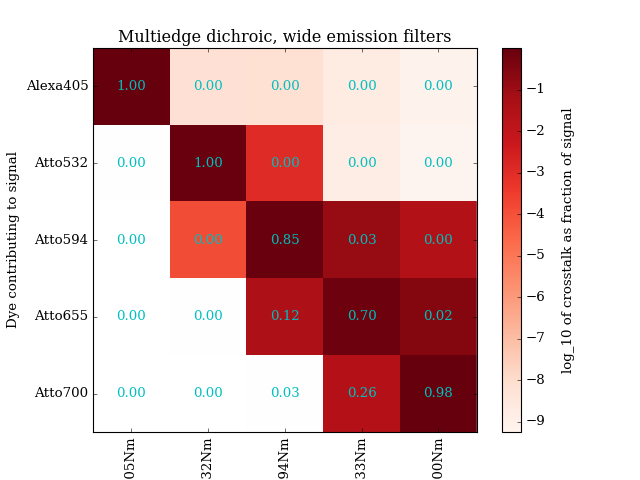

In [8]:
multi_fc_list_maxem = [fc405multi, fc532multi, fc594multi4, fc633multi3, fc700multi]

displayCrosstalkPlot(laser_list, 
                     multi_fc_list_maxem, 
                     dye_list, 
                     objective, camera)

plt.title('Multiedge dichroic, wide emission filters')